# Smart Charging Using Reinforcement Learning

In [1]:
import numpy as np
import tqdm
from collections import defaultdict
import gymnasium as gym

import reinforcement

## Learning Resources and environments we can use

- OpenAI gym
    - [Official Gymnasium GitHub](https://github.com/Farama-Foundation/Gymnasium)
    - [Gymnasium Docu](https://gymnasium.farama.org/)
        - [Creating a Gymnasium Environment](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/)
        - [Lunar Lander example](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
    - [OpenAI Learning platform for Gymnasium](https://spinningup.openai.com/en/latest/index.html)
        - [OpenAI Algorithms](https://spinningup.openai.com/en/latest/algorithms/ddpg.html#background)

- [Here is a good resource for all deep-RL algorithms](https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/README.md) (look into the results folder)

## Finite Markov Decision Process (MDP)

A **Markov Process** (or Markov Chain) is a tuple ⟨S, A, P, R⟩
- S is a set of **states**
    - States: time, battery_level
        - time: Discrete 15-minute intervals from 2 p.m. to 4 p.m. (count down?)
        - battery_level: The current battery level (from 0 kWh to battery capacity kWh)
- A is a set of **actions**
    - Actions: {zero: 0 kW, low: 8 kW, medium: 16 kW, high: 24 kW}
        - The actions are the discrete charging rates that the agent can choose at each discrete timestep.
- P is a state **transition probability** function, (P<sup>a</sup><sub>SS'</sub> = P[S<sub>t</sub> = s'| S<sub>t-1</sub> = s, A<sub>t-1</sub> = a])
- R is a **reward** function of states and actions
    - Reward:
        - Running out of energy: -10000
        - Charging costs:  charging cost (t,p) = ∑<sub>𝑡∈𝑇</sub> 𝑒<sup>𝑝</sup>, where p is the charging rate in kWh.
    
**Goal:** Finding the optimal policies (which action to take in different states)  
**Trade-off:** The agent’s goal is to avoid running out of energy (you should consider a very high penalty for running out of energy) and to minimize the recharging cost.

**Further Assumptions:**
- We use values that can easily be mapped into kWh without resulting in floats
- Battery capacity: 44 kWh 
- Energy demand function: stochastic value following a normal distribution
    - Parameters: 𝜇= 30 kWh, 𝜎 = 5 kWh (Note: must be generated exactly when the driver wants to leave.)

The Implementation of this MDP as an custom gym environment is in reinforcemnt.py.

## First RL-model: SARSA (TD control problem, On-Policy)

**Define our Agent**

In [2]:
class SarsaAgent:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, observation: tuple[int, int, bool], env) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[observation]))

    def update(
        self,
        observation: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_observation: tuple[int, int, bool],
        next_action: int,
    ):
        """Updates the Q-value of an action."""
        target_q_value = (not terminated) * self.q_values[next_observation][next_action]
        temporal_difference = (
            reward + self.discount_factor * target_q_value - self.q_values[observation][action]
        )

        self.q_values[observation][action] = (
            self.q_values[observation][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

**Main Loop for learning**

In [3]:
def run_sarsa_learning(env, sarsa_agent, n_episodes, **kwargs):
    for episode in tqdm.tqdm(range(n_episodes)):
        observation, info = env.reset()
        action = sarsa_agent.get_action(observation, env)
        done = False

        # play one episode
        while not done:
            next_observation, reward, terminated, truncated, info = env.step(action)
            next_action = sarsa_agent.get_action(next_observation, env)

            # update the agent
            sarsa_agent.update(observation, action, reward, terminated, next_observation, next_action)

            # update if the environment is done and the current observation
            done = terminated or truncated
            observation = next_observation
            action = next_action

        sarsa_agent.decay_epsilon()

**Run Training**

In [4]:
# hyperparameters
n_episodes = 250000
learning_rate = 0.005
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = reinforcement.SmartChargingEnv()
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

sarsa_agent = SarsaAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

run_sarsa_learning(env, sarsa_agent, n_episodes)

/home/max/Project_AAA/.venv/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 250000/250000 [01:50<00:00, 2265.50it/s]


**Plot Results**

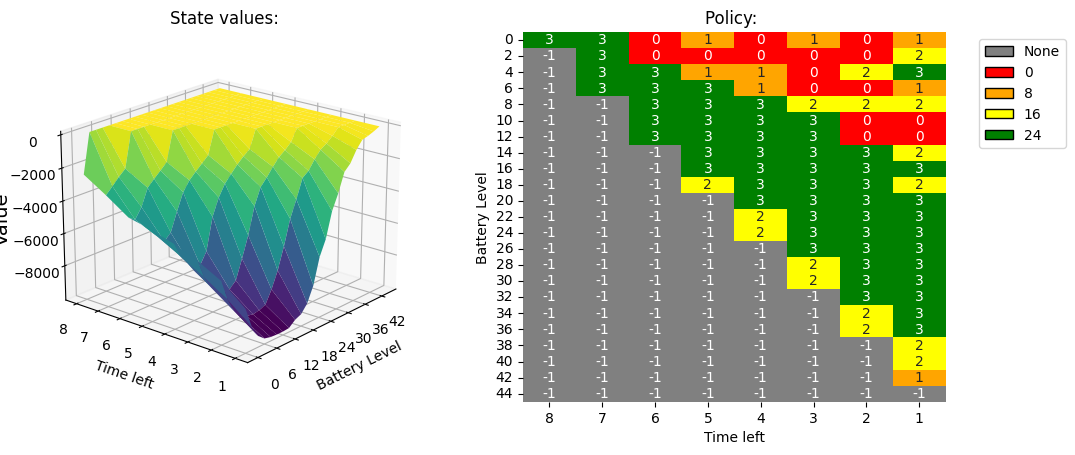

In [5]:
# state values & policy
value_grid, policy_grid = reinforcement.create_grids(sarsa_agent.q_values)
fig1 = reinforcement.create_policy_plots(value_grid, policy_grid)

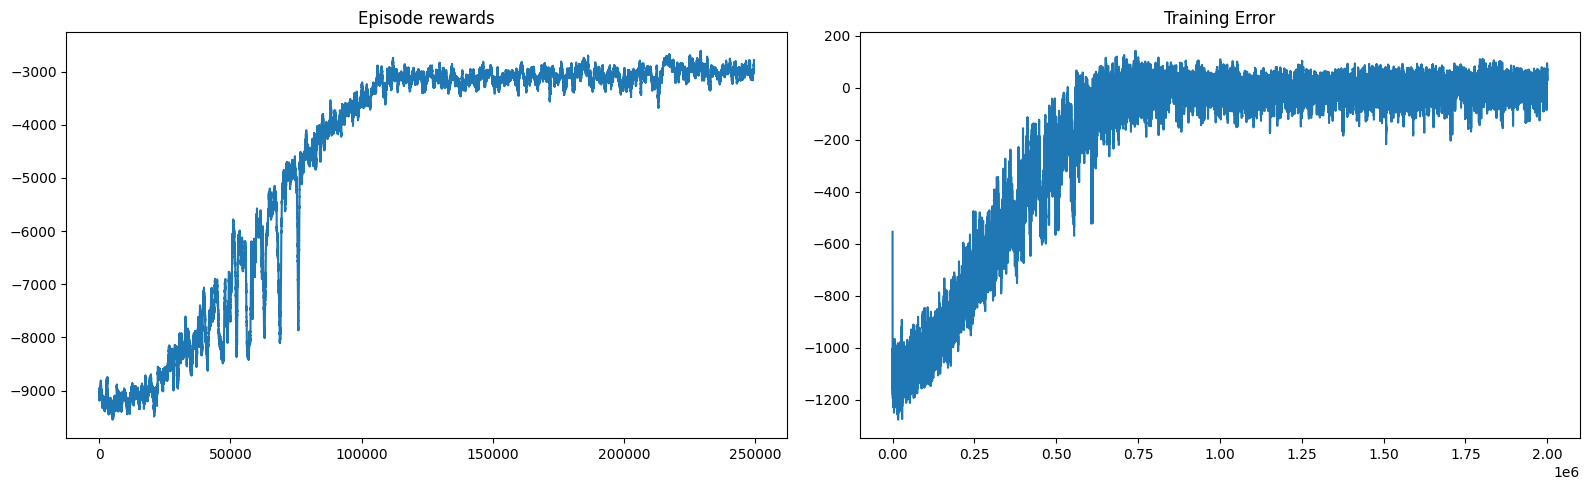

In [6]:
reinforcement.plot_training_performance(env, sarsa_agent)

In [7]:
env.close()